In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from tensorflow.keras import backend
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.applications import InceptionV3, ResNet152V2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf # thêm

In [2]:
!pip install --upgrade keras

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
base_skin_dir = os.path.join('/content/gdrive/MyDrive/Dữ liệu','data')
print(base_skin_dir)

/content/gdrive/MyDrive/Dữ liệu/data


In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, '/content/gdrive/MyDrive/Dữ liệu/HAM10000_metadata.csv')) # create skin data frame(skin_df) contain csv file
print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [8]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [9]:
print(skin_df['image_id'].map(imageid_path_dict.get))

0        /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
1        /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
2        /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
3        /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
4        /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
                               ...                        
10010    /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
10011    /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
10012    /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
10013    /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
10014    /content/gdrive/MyDrive/Dữ liệu/data/HAM10...
Name: image_id, Length: 10015, dtype: object


In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/gdrive/MyDrive/Dữ liệu/data/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/gdrive/MyDrive/Dữ liệu/data/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/gdrive/MyDrive/Dữ liệu/data/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/gdrive/MyDrive/Dữ liệu/data/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/gdrive/MyDrive/Dữ liệu/data/HAM10...,Benign keratosis-like lesions,2


In [10]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [12]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='cell_type'>

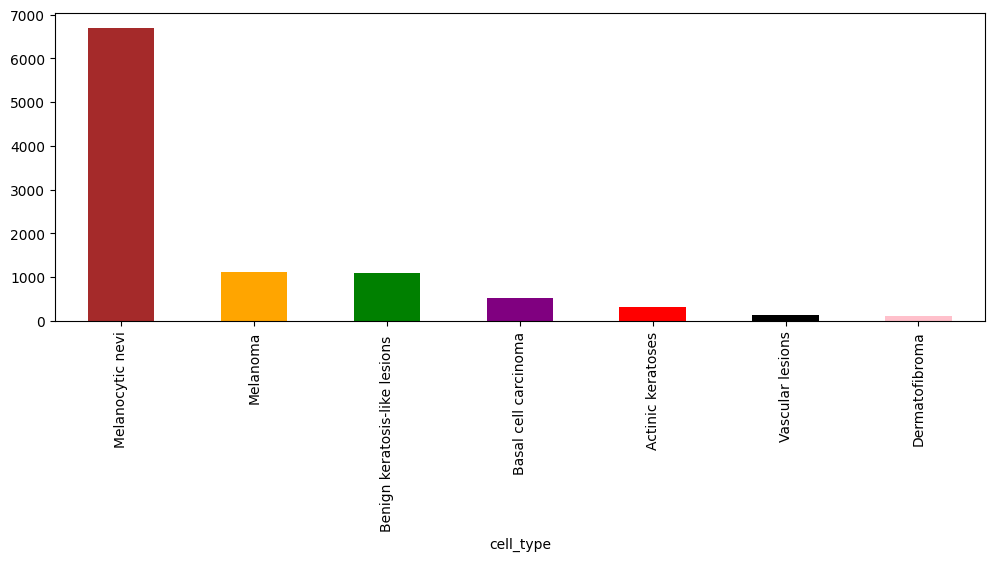

In [ ]:
plt.figure(figsize=(12, 4)) #width: 12 inches, height: 4 inches
skin_df['cell_type'].value_counts().plot(kind='bar', color=["brown", "orange", "green", "purple", "red", "black","pink"])

In [ ]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='dx_type'>

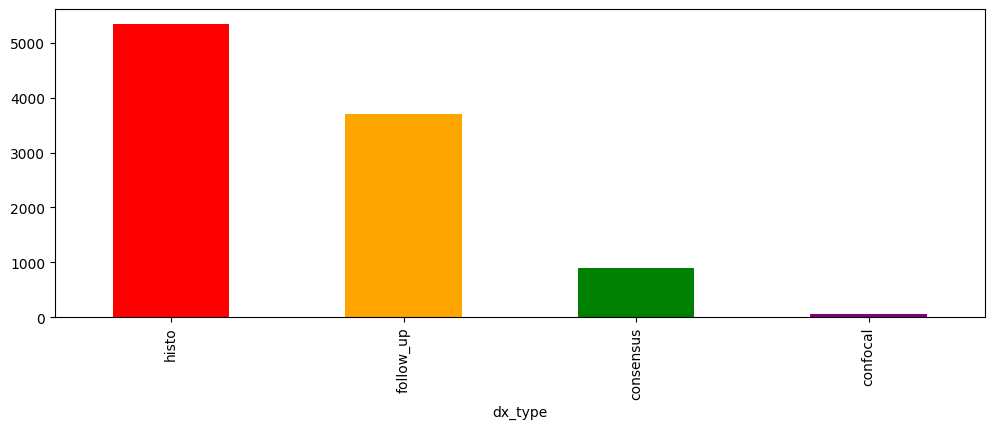

In [ ]:
plt.figure(figsize=(12, 4))
skin_df['dx_type'].value_counts().plot(kind='bar', color=["red", "orange", "green", "purple"])

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='localization'>

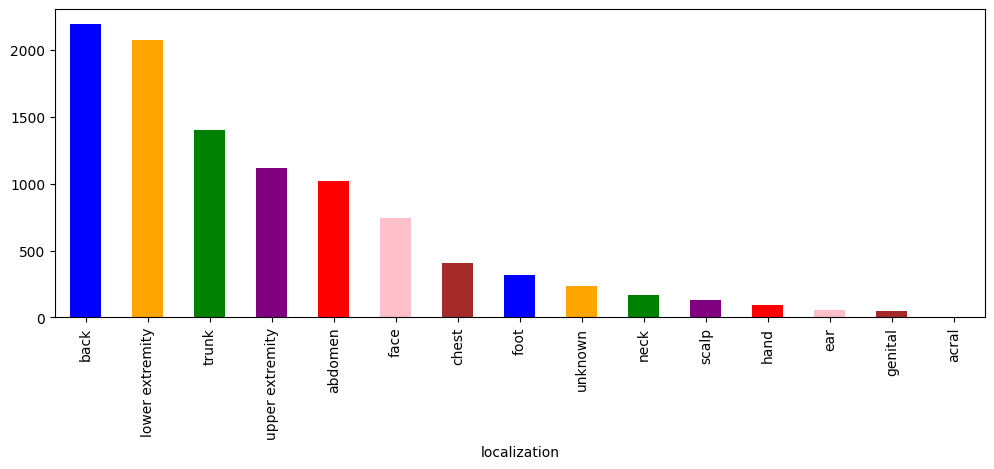

In [ ]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

<Axes: >

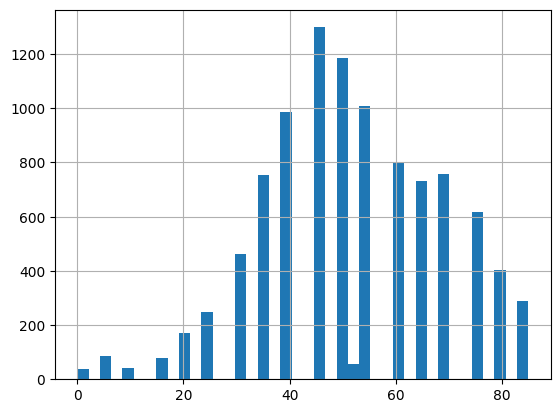

In [ ]:
skin_df['age'].hist(bins=40)

<Figure size 600x600 with 0 Axes>

<Axes: ylabel='count'>

(-1.1140905315676273,
 1.12162000951539,
 -1.1049587115962414,
 1.2041801524406666)

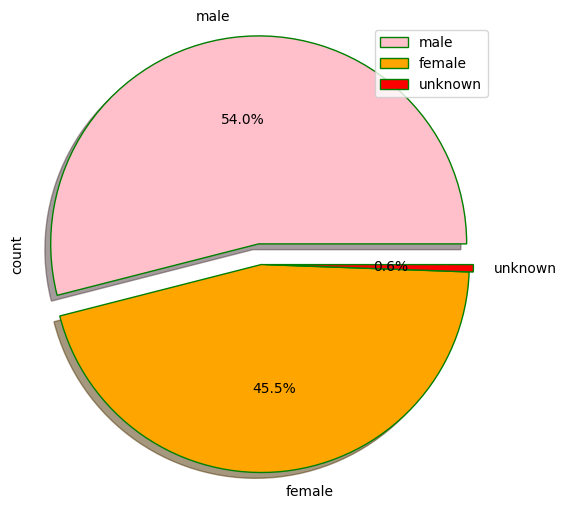

In [ ]:
plt.figure(figsize=(6, 6))
wp = { 'linewidth' : 1, 'edgecolor' : "green" }
explode = [0.1,0,0.02]
skin_df['sex'].value_counts().plot(kind='pie', colors=["pink", "orange", "red"],shadow = True,wedgeprops=wp,  explode= explode,autopct='%1.1f%%')

plt.axis('equal')  # Đảm bảo biểu đồ hình tròn có tỷ lệ 1:1

plt.legend(labels=skin_df['sex'].unique())

In [13]:
im = Image.open(skin_df["path"][0]) # maybe first image
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [14]:
width= 100
height= 75

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))

In [ ]:
skin_df['image'] = skin_df['image'].map(lambda x: x.resize((100,75)))

In [ ]:
skin_df.head(5)

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

(-0.5, 99.5, 74.5, -0.5)

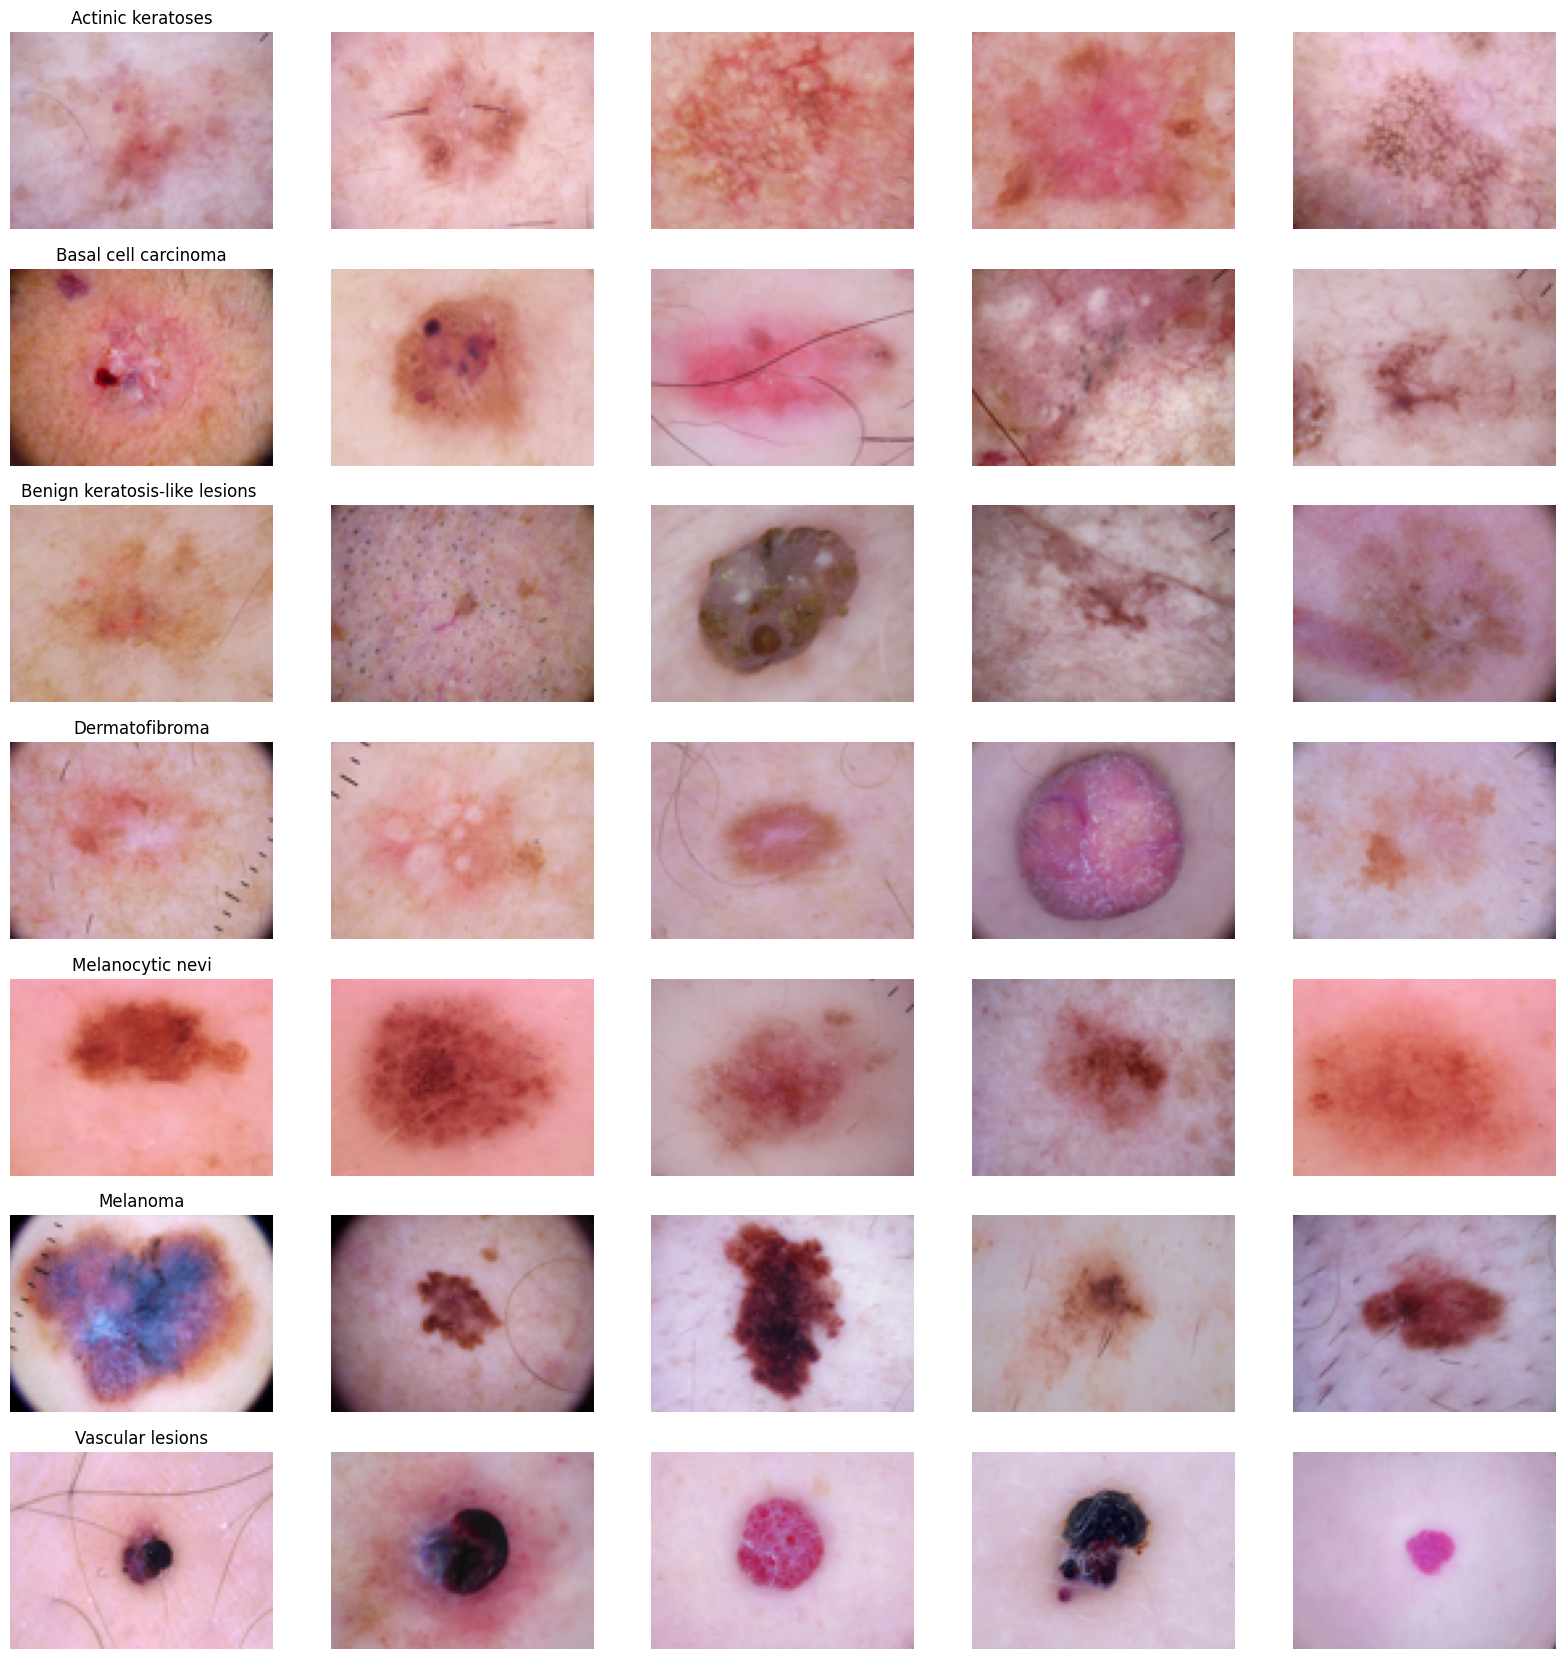

In [ ]:
n_samples = 5 # 5 samples for each
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7)) #fig: hình ảnh, m_axs: lưới
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('/content/gdrive/MyDrive/Dữ liệu/photo/category_samples.png', dpi=300)

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(features, target, test_size=0.20, random_state=123)

In [ ]:
# Load and preprocess images for training and testing
x_train = np.asarray(train_set_x['image'].tolist())
x_test = np.asarray(test_set_x['image'].tolist())

# Normalize the data
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(train_set_y, num_classes=7)
y_test = to_categorical(test_set_y, num_classes=7)



In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configure GPU memory allocation
        print("Num GPUs available: ", len(tf.config.experimental.list_physical_devices("GPU")))
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
def build_two(input_shape, num_classes, learning_rate, loss):

    # Create a Sequential model
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    # Add the output layer with 'softmax' activation for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Print a summary of the model architecture
    model.summary()

    # Define the optimizer with specified learning rate and other parameters
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

    # Compile the model with categorical cross-entropy loss and accuracy metric
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Return the constructed model
    return model

In [ ]:
input_shape = (75, 100, 3)
num_classes = 7
learning_rate = 1e-5
loss = 'categorical_crossentropy'

# Create the convolutional neural network model using the build_one function
model = build_two(input_shape = input_shape, num_classes = num_classes, learning_rate = learning_rate, loss = loss)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 75, 100, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 37, 50, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 35, 48, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 33, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 23, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 19, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 58368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 58368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      14,942,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │              

 Total params: 15,380,775 (58.67 MB)

 Trainable params: 15,379,655 (58.67 MB)

 Non-trainable params: 1,120 (4.38 KB)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

In [ ]:

# Create an ImageDataGenerator object for data augmentation and transformation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=10
)




In [ ]:
epochs = 10
batch_size = 128

# Create a learning rate reduction callback
# This callback monitors the validation accuracy and reduces the learning rate if it doesn't improve for a specified number of epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
# Fit the model using data augmentation with ImageDataGenerator
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),  # Data generator for training data
    validation_data=(x_val, y_val),                         # Use Validation Data, since 'split' isn't compatible with ImageDataGenerator
    epochs=epochs,                                          # Number of training epochs
    batch_size=batch_size,                                  # Batch size
    shuffle=True,                                           # Shuffle the training data
    callbacks=[learning_rate_reduction]                     # Callbacks for training
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 4/57 ━━━━━━━━━━━━━━━━━━━━ 35:37 40s/step - accuracy: 0.3338 - loss: 3.9027

KeyboardInterrupt: 

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

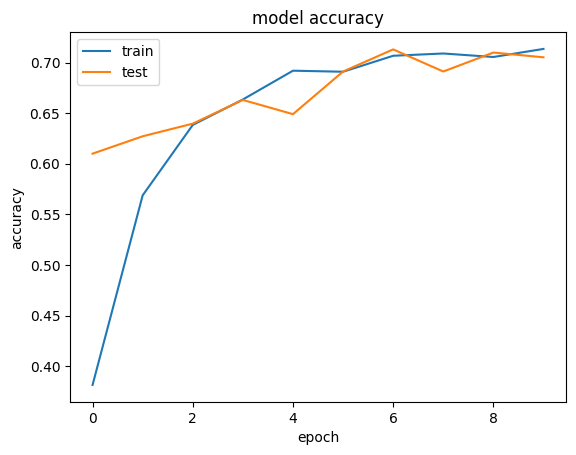

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

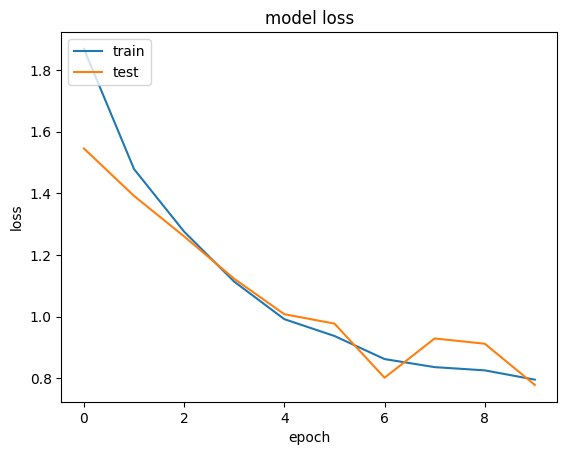

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
highest_accuracy = max(history.history['accuracy'])
print("Highest Accuracy:", highest_accuracy)

Highest Accuracy: 0.7134188413619995


In [ ]:
from sklearn import metrics
class_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

In [ ]:
y_true_labels = np.argmax(y_test, axis=1)

# Get predictions from the model
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Classification report:\n%s\n" % (classification_report(y_true_labels, y_pred_labels, target_names=class_types)))


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step
Classification report:
              precision    recall  f1-score   support

          nv       0.24      0.08      0.12        64
         mel       0.32      0.52      0.40       100
         bkl       0.40      0.50      0.44       225
         bcc       0.00      0.00      0.00        24
       akiec       0.83      0.88      0.85      1320
        vasc       0.47      0.25      0.33       240
          df       0.00      0.00      0.00        30

    accuracy                           0.70      2003
   macro avg       0.32      0.32      0.31      2003
weighted avg       0.67      0.70      0.67      2003




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


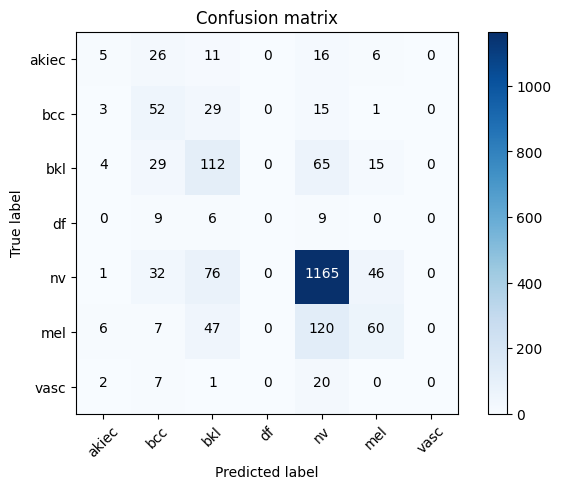

In [ ]:
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)
plot_confusion_matrix(confusion_mtx,classes = cm_plot_labels)


In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step


In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

0.6959560659011482


<BarContainer object of 7 artists>

Text(0.5, 0, 'True Label')

Text(0, 0.5, 'Fraction classified incorrectly')

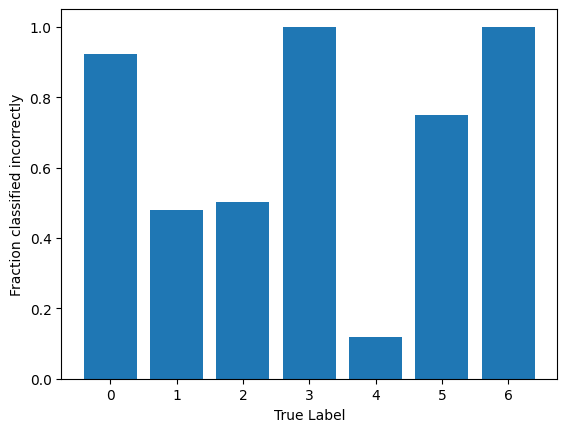

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

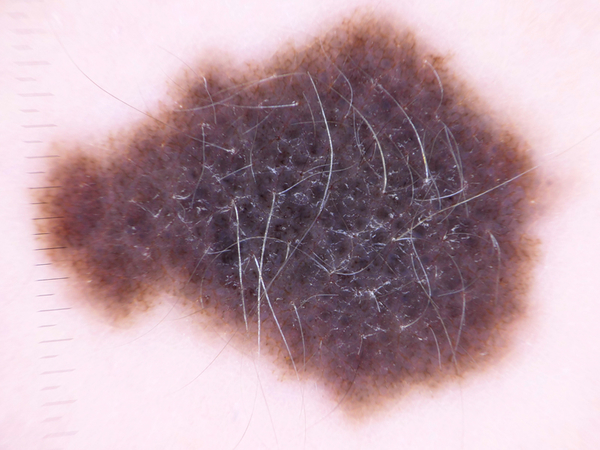

In [ ]:
image = Image.open('/content/gdrive/MyDrive/Dữ liệu/data/HAM10000_images_part_1/ISIC_0024752.jpg')
image

In [ ]:
image = image.resize((75, 100))
img = np.asarray(image).reshape(1, 75, 100, 3)
img = img/255.0

# Make a prediction using the model
result = model.predict(img)
result = result.tolist()
print(f"{result[0]}\n")

max_prob = max(result[0])
class_ind = result[0].index(max_prob)

lesion_type_keys = list(lesion_type_dict.keys())
class_shorthand = lesion_type_keys[class_ind]

if class_shorthand in lesion_type_dict:
    correct_name = lesion_type_dict[class_shorthand]
    correct_shorthand = class_shorthand
    print(f"Predicted lesion type: {correct_name} ({correct_shorthand})")
else:
    print(f"Unable to identify the lesion type.")

# In ra kết quả dự đoán chi tiết
for i, probability in enumerate(result[0]):
    class_shorthand = lesion_type_keys[i]
    if class_shorthand in lesion_type_dict:
        class_names = lesion_type_dict[class_shorthand]
        print(f"{class_names} ({class_shorthand}): {probability * 100:.2f}%")

print(f"\nModel's Answer: {correct_name} ({correct_shorthand})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[0.014057309366762638, 0.13027925789356232, 0.13391435146331787, 0.022846518084406853, 0.6653470396995544, 0.01865554414689541, 0.014899996109306812]

Predicted lesion type: Actinic keratoses (akiec)
Melanocytic nevi (nv): 1.41%
Melanoma (mel): 13.03%
Benign keratosis-like lesions  (bkl): 13.39%
Basal cell carcinoma (bcc): 2.28%
Actinic keratoses (akiec): 66.53%
Vascular lesions (vasc): 1.87%
Dermatofibroma (df): 1.49%

Model's Answer: Actinic keratoses (akiec)


In [ ]:
model.save('/content/gdrive/MyDrive/Dữ liệu/skin_cancer_model_03.h5')